# Replication Notebook of Jeppe Druedahl (2021): A Guide on Solving Non-convex Consumption-Saving Models

### Author: Adrian Monninger

This notebook replicates a consumption-savings problem with non-durable and durable consumption subject to adjustment costs solved with the nested endogeneous grid method by Druedahl (2021). The only difference is that the original code has persistent income as an additional state variable while this example uses only variables normalized by permanent income.

I will start specifying the problem, show results of the original code, and provide code examples how the newly created `DurableConsumerType` in econ-ark can be used. Afterwards, I compare it with the `IndShockConsumerType` and show some bottleneck cases of the code.

## The DurableConsumerType
The `DurableConsumerType` inherits many attributes from the `IndShockConsumerType`. The only difference is that a durable good provides a flow of consumption services which enter the utility function as well. Hence, each household has the utility function:
\begin{align}
    u(c_t, d_t) &= \frac{(c_t^\alpha (d_t + \underline{d})^{1 - \alpha})^{1 - \rho}}{1 - \rho}
\end{align}
Where $c_t$, and $d_t$ is the non-durable and durable consumption, $\rho$ is the coefficient of relative risk aversion, and $\alpha$ is the Cobb-Douglas parameter.

Each period, the household can adjust the stock of durable goods $n_t$ which incurs a proportional adjustment cost $\tau \in (0,1)$. Hence, in case of adjustment, the cash-on-hand after selling the beginning-of-period stock of durables is: $x_t = m_t + (1 - \tau)n_t$ which then can be saved or used to purchase durables and non-durables.

Therefore, the household's end of period assets $a_t = x_t - c_t - d_t$. The consumer cannot borrow $a_t \geq 0$ and he interest rateis $r$. Hence, next-period cash-on-hand is
\begin{align}
    m_{t+1} &= Ra_t + y_{t+1}
\end{align}

The durable stock depreciates each period with rate $\delta \in (0,1)$:
\begin{align}
    n_{t+1} = (1 - \delta)n_t
\end{align}

The Bellman Equation is given by the maximum over the value functions of keeping $d_t = n_t$, and adjusting $d_t \neq n_t$. Or:
\begin{align}
    v_t(n_t,m_t) &= \max_{c_t, d_t} \Big(v_t^{keep}(n_t,m_t), v_t^{adj}(n_t, m_t) \Big)\\
    & \text{s.t.}\\
    a_t &= \begin{cases}
    m_t - c_t \geq 0  & \text{ if keep}\\
    x_t - c_t - d_t \geq 0 & \text{ if adjust}
    \end{cases}\\
    m_{t+1} &= Ra_t + y_{t+1}\\
    n_{t+1} &= (1 - \delta)n_t
\end{align}

Where we have the Bellman for the keeper:
\begin{align}
    v_t^{keep}(n_t,m_t) &= \max_{c_t} u(c_t,n_t) + \beta \mathbb{E}_t \Big(v_{t+1}(n_{t+1}, m_{t+1})\Big)\\
    & \text{s.t.}\\
    a_t &= m_t - c_t \geq 0 \\
    m_{t+1} &= Ra_t + y_{t+1}\\
    n_{t+1} &= (1 - \delta)n_t
\end{align}

And for the adjuster
\begin{align}
    v_t^{adj}(x_t) &= \max_{c_t,n_t} u(c_t,n_t) + \beta \mathbb{E}_t \Big(v_{t+1}(n_{t+1}, m_{t+1})\Big)\\
    & \text{s.t.}\\
    a_t &= x_t - c_t - d_t\geq 0 \\
    m_{t+1} &= Ra_t + y_{t+1}\\
    n_{t+1} &= (1 - \delta)n_t
\end{align}

### Implementation (nested endogeneous grid-method)
The nested endogeneous grid method takes advantage of the fact, that the post-decision value function is the same for adjuster and keeper:
\begin{align}
    w_t(d_t, a_t) = \beta E[v_{t+1} (n_{t+1}, m_{t+1})].
\end{align}
Hence, the keeper problem gets:
\begin{align}
    v_t^{keep}(n_t,m_t) &= \max_{c_t} u(c_t,n_t) + w_t(d_t, a_t)\\
    & \text{s.t.}\\
    a_t &= m_t- c_t \geq 0 \\
    m_{t+1} &= Ra_t + y_{t+1}\\
    n_{t+1} &= (1 - \delta)n_t
\end{align}
Where we maximize the value function for each combination of beginning-of-period durable stock ($n_t$), and market resources ($m_t)$. Additionally, when we think of the problem as sequential, meaning first the optimal durable consumption $d_t$ is determined, and then how much to consume and save, we can write:
\begin{align}
    v_t^{adj}(x_t) &= \max_{d_t} v_t^{keep}(n_t,m_t)\\
    & \text{s.t.}\\
    a_t &= x_t - c_t - d_t \geq 0 \\
    m_{t+1} &= Ra_t + y_{t+1}\\
    n_{t+1} &= (1 - \delta)n_t
\end{align}
Eg, optimize the value function of the keepers problem wrt $d_t$.

The idea is the following: The adjuster has total resources $x$ and decides how to split them into $c_t, d_t$, and $a_t$. From the keeper problem, we know $m_t = a_t + c_t$. Therefore, we can think about splitting $x$ into $d$ and $m$. But remember, that the value function for the keeper for $(n_t, m_t)$ and $(d_t, m_t)$ is the same as durables do not change! Therefore, we already have the value of each combination of $m$ and $d$ and just pick the optimal point!

For the EGM part, we need the Euler equation:
\begin{align}
    u_c(c_t, d_t) &= \alpha c_t^{\alpha(1 - \rho) - 1} d_t^{(1 - \alpha)(1 - \rho)} = q_t(d_t, a_t)
\end{align}
The idea is that we fix the end-of-perid states for durables $d_t$ and assets $a_t$ . Next, we take the expectation of how these end-of-period states in period $t$ transition into beginning-of-period states (m_{t+1}, n_{t+1}) and evaluate the beginning-of-period marginal value function with respect to $c_t$. Now, we are in a position to use the Euler-equation and the budget constraint to infer respectively the consumption choice $c_t$ and the level of cash-on-hand $m_t$.

Additionally, as we have a discrete choice, we need to apply an upper-envelope algorithm. This is necessary, as we have a discrete choice of adjusting or not-adjusting. At the beginning of period state combinations at which we transition from keeping to adjusting, the value function takes a dip due to the presence of adjusting costs. Hence, for different policy choices of $c_t$ and $d_t$, we get the same utility. Thus, the value function is not concave anymore! To deal with that, we use this algorithm which essentially gets rid of the parts of the value function which are decreasing.

### Implementation Steps:
1. Compute the post-decision functions $w_t$ and $q_t$ on a grid over the post-decision states $d_t, a_t$
2. Solve the keeper problem on a grid over the pre-decision states $n_t, m_t$ where the combined EGM and upper envelope is applied for each $n_t$
3. Solve the adjuster problem using interpolation of the keeper value function found in step 2.

### Original Source
Jeppe Druedahl published a notebook:
https://github.com/NumEconCopenhagen/ConsumptionSavingNotebooks 

#### Useful HARK notebooks:
1. Discrete choice (retirement decision)
https://github.com/econ-ark/EndogenousRetirement/blob/master/Endogenous-Retirement.ipynb
2. Upper Envelope Theorem
https://github.com/econ-ark/DemARK/blob/master/notebooks/DCEGM-Upper-Envelope.ipynb
3. How the IndShockConsumerType works 
https://github.com/econ-ark/HARK/blob/master/examples/HowWeSolveIndShockConsumerType/HowWeSolveIndShockConsumerType.ipynb


# 1. The original Code (with persistent income component)

In [1]:
# Installing necessary codes
!pip install EconModel
!pip install ConSav

In [2]:
%load_ext autoreload
%autoreload 2

import time
import numpy as np

# load the DurableConsumptionModel module
import sys
sys.path.insert(0, './ConsumptionSavingOrig')
sys.path.insert(0, './ConsumptionSavingNormalized')

from DurableConsumptionModel import DurableConsumptionModelClass

import numba as nb
nb.set_num_threads(8)

T = 5

In [3]:
model_negm = DurableConsumptionModelClass(name='example_negm',par={'solmethod':'negm','T':T,'do_print':True})
model_negm.precompile_numba() # solve with very coarse grids
model_negm.solve()

start = time.time()
model_negm.solve()

end = time.time()
time_original = end - start
print("time used: ", time_original, " seconds")

numba precompiled in 73.6 secs
 t = 4 solved in 0.0 secs
  w computed in 0.2 secs
  solved keeper problem in 0.0 secs
  solved adjuster problem in 0.0 secs
 t = 3 solved in 0.2 secs
  w computed in 0.2 secs
  solved keeper problem in 0.0 secs
  solved adjuster problem in 0.0 secs
 t = 2 solved in 0.5 secs
  w computed in 0.2 secs
  solved keeper problem in 0.1 secs
  solved adjuster problem in 0.0 secs
 t = 1 solved in 0.7 secs
  w computed in 0.2 secs
  solved keeper problem in 0.1 secs
  solved adjuster problem in 0.0 secs
 t = 0 solved in 1.0 secs
 t = 4 solved in 0.0 secs
  w computed in 0.2 secs
  solved keeper problem in 0.0 secs
  solved adjuster problem in 0.0 secs
 t = 3 solved in 0.2 secs
  w computed in 0.2 secs
  solved keeper problem in 0.0 secs
  solved adjuster problem in 0.0 secs
 t = 2 solved in 0.5 secs
  w computed in 0.2 secs
  solved keeper problem in 0.0 secs
  solved adjuster problem in 0.0 secs
 t = 1 solved in 0.7 secs
  w computed in 0.2 secs
  solved keeper p

In [4]:
model_negm.decision_functions()

interactive(children=(Dropdown(description='t', options=(0, 1, 2, 3, 4), value=0), Dropdown(description='ip', …

# 2. The normalized version
As all HARK models are normalized by permanent income and do not have a persistent component, I tranfrom the code such that we only have two state variables: durable stock (n) and market resources (m).

In the code example, it is not a problem as the original has a persistent factor of one, but allows for other values. Thus, we get the same picture, with one state variable less.

In [5]:
from DurableConsumptionModel_NrM import DurableConsumptionModelClass_NrM

In [6]:
model_negm_NrM = DurableConsumptionModelClass_NrM(name='example_negm_NrM',par={'solmethod':'negm','T':T,'do_print':True})
model_negm_NrM.precompile_numba() # solve with very coarse grids
start = time.time()
model_negm_NrM.solve()
end = time.time()
time_NrM = end - start
print("time used: ", time_NrM, " seconds")

C:\Users\adria\anaconda3\envs\Durable\lib\site-packages\numba\core\typed_passes.py:329: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "ConsumptionSavingNormalized\nvfi_NrM.py", line 95:
@njit(parallel=True)
def solve_adj(t,sol,par):
^

  warnings.warn(errors.NumbaPerformanceWarning(msg,


time used:  3.9876279830932617  seconds


In [7]:
model_negm_NrM.decision_functions()

interactive(children=(Dropdown(description='t', options=(0, 1, 2, 3, 4), value=0), Dropdown(description='name'…

# 3. HARK Version `DurableConsumerType`
Now, we use the `DurableConsumerType` and compare solutions.

In [9]:
### Import
import numpy as np
from copy import deepcopy
from DurableModel_Nested_EGM import DurableConsumerType_Latest, construct_grid
from utilities_Durable import decision_function_latest
from HARK.ConsumptionSaving.ConsIndShockModel import IndShockConsumerType, ConsumerSolution, init_idiosyncratic_shocks
import time # to time

from HARK.utilities import plot_funcs_der, plot_funcs
import matplotlib.pyplot as plt

As always, we create a dictionary with initial values. Note that we have to specify additional variables such as `alpha`, `dDepr`, or `adjC`.

In [10]:
T_cycle = T - 1
init_durable = dict(
    init_idiosyncratic_shocks,
    **{
        #
        "DiscFac": [0.965] * T_cycle,
        "Rfree": [1.03] * T_cycle,
        "LivPrb": [1.0] * T_cycle,
        ### No income shocks
        "PermGroFac": [1.0] * T_cycle,
        "PermShkCount": 5,
        "PermShkStd": [0.1] * T_cycle,
        "TranShkStd": [0.1] * T_cycle,
        "TranShkCount": 5,
        "UnempPrb": [0.0] * T_cycle,
        "UnempPrbRet": [0.0] * T_cycle,
        "IncUnemp": [0.0] * T_cycle,
        # Durable Specific
        "alpha": 0.9, # Cobb-Douglas parameter for non-durable good consumption in utility function
        "dDepr": 0.15, # Depreciation Rate of Durable Stock
        "adjC": 0.1, # Adjustment costs
        "d_ubar": 0.02, # Minimum durable stock for utility function
        # For Grids
        "nNrmMin": 0.0,
        "nNrmMax": 3.0,
        "mNrmMin": 0.0,
        "mNrmMax": 10.0,
        "mNrmCount": 100,
        "xNrmMin": 0.0,
        "xNrmMax": 13.0,
        "xNrmCount": 100,
        "aNrmMin": 0.0,
        "aNrmMax": 11.0,
        "aNrmCount": 100,
        ### Others
        "BoroCnstArt": [0.0] * T_cycle,
        "BoroCnstdNrm": 0, # Borrowing Constraint of durable goods.
        "cycles": 1,
        "T_cycle": 4,
        "tol": 1e-08,
        # To construct grids differently
        "NestFac": 3, 
        "grid_type": 'nonlinear',
    }
)

In [11]:
### Solve and time
DurableReplication = DurableConsumerType_Latest(**init_durable)
DurableReplication.update_income_process()
DurableReplication.solve()#(verbose=False)
start = time.time()
DurableReplication.solve()#(verbose=False)
end = time.time()
time_HARK = end - start
print("time used: ", time_HARK, " seconds")

time used:  3.8561675548553467  seconds


In [12]:
decision_function_latest(DurableReplication)

interactive(children=(Dropdown(description='t', options=(0, 1, 2, 3, 4), value=0), Dropdown(description='name'…

In [13]:
# Compare speeds:
print("Using the same number of gridpoints for each grid: 100, the speed improvements are:")
print("Original: ", time_original)
print("Normalized Version: ", time_NrM)
print("HARK Version: ", time_HARK)

Using the same number of gridpoints for each grid: 100, the speed improvements are:
Original:  0.8728415966033936
Normalized Version:  3.9876279830932617
HARK Version:  3.8561675548553467


In [14]:
### What is saved:
print(vars(DurableReplication.solution[0]))

{'cFunc': <HARK.econforgeinterp.LinearFast object at 0x000001E8C46318E0>, 'cFuncAdj': <HARK.econforgeinterp.LinearFast object at 0x000001E8C4631C70>, 'cFuncKeep': <HARK.interpolation.LowerEnvelope2D object at 0x000001E8C46317C0>, 'dFunc': <HARK.econforgeinterp.LinearFast object at 0x000001E8C4631CD0>, 'dFuncAdj': <HARK.econforgeinterp.LinearFast object at 0x000001E8C4631970>, 'dFuncKeep': <HARK.interpolation.LowerEnvelope2D object at 0x000001E8C46319A0>, 'exFunc': <HARK.econforgeinterp.LinearFast object at 0x000001E8C4631F70>, 'exFuncAdj': <HARK.econforgeinterp.LinearFast object at 0x000001E8C4631C10>, 'exFuncKeep': <HARK.interpolation.LowerEnvelope2D object at 0x000001E8C4631A00>, 'vFunc': <HARK.interpolation.ValueFuncCRRA object at 0x000001E8C463E400>, 'vFuncAdj': <HARK.interpolation.ValueFuncCRRA object at 0x000001E8C4631E50>, 'vFuncKeep': <HARK.interpolation.ValueFuncCRRA object at 0x000001E8C4631C40>, 'vPFunc': <utilities_Durable.MargValueFuncCRRA_dur object at 0x000001E8C463E1C0>

### What is new:
1. Separate functions for the keeper's and adjuster's problem: FuncKeep, FuncAdj
2. dFunc: For durable expenditure
3. exFunc: Total expenditure function (non-durable (c) + durable (d) expenditure)
4. adjusting: Indicating if the agent should adjust (1) or keep (0).

# 4. Comparison with `IndShockConsumerType`
After we established that the new function does exactly the same as in Druedahl (2021), let's focus on the type itself. First, we compare it with the `IndShockConsumerType` in HARK.

With `alpha = 1`, the consumer derives only utility from the non-durable goods they consume. Hence, the problem boils down to exactly the same for the `IndShockConsumerType`.

In [17]:
#### For Comparison, define parameters for the IndShockConsumerType
init_indshock = dict(
    init_idiosyncratic_shocks,
    **{
        ### No income shocks
        "PermGroFac": [1.0] * T_cycle,
        "PermShkStd": [0.0] * T_cycle,
        "TranShkStd": [0.0] * T_cycle,
        "UnempPrb": 0.0,
        "UnempPrbRet": 0.0,
        "IncUnemp": 0.0,
        "Rfree": 1.03,
        "DiscFac": 0.965,
        "LivPrb": [1.0] * T_cycle,
        ### Others
        "BoroCnstArt": 0,
        "BoroCnstdNrm": 0, # Borrowing Constraint of durable goods.
        "cycles": 1,
        "T_cycle": T_cycle,
        "tol": 1e-08,
    }
)

nGridpoints = 48  # Number of Gridpoints for solution (a, m, x)
dGridpoints = 2  # Number of Gridpoints for solution n

init_durable_indshock_comp = {
    # Parameters shared with the perfect foresight model
    "CRRA": 2,  # Coefficient of relative risk aversion
    "DiscFac": [0.965] * T_cycle, # Intertemporal discount factor
    "Rfree": [1.03] * T_cycle,
    "LivPrb": [1.00] * T_cycle,
    "PermGroFac": [1.00] * T_cycle,  # Permanent income growth factor

    # Parameters that specify the income distribution over the lifecycle
    "PermShkStd": [0.0] * T_cycle,
    "TranShkStd": [0.0] * T_cycle,
    "UnempPrb": [0.0] * T_cycle,  # Probability of unemployment while working
    "IncUnemp": [0.0] * T_cycle,  # Unemployment benefits replacement rate
    "UnempPrbRet": [0.0] * T_cycle,  # Probability of "unemployment" while retired
    "IncUnempRet": [0.0] * T_cycle,  # "Unemployment" benefits when retired
    "T_retire": 0,  # Period of retirement (0 --> no retirement)
    "tax_rate": 0.0,  # Flat income tax rate (legacy parameter, will be removed in future)

    # A few other parameters
    "BoroCnstArt": [0.0] * T_cycle,  # Artificial borrowing constraint; imposed minimum level of end-of period assets
    "vFuncBool": False,  # Whether to calculate the value function during solution
    "CubicBool": False,  # Preference shocks currently only compatible with linear cFunc
    "T_cycle": T_cycle,  # Number of periods in the cycle for this agent type

    # VARIABLES FOR DURABLECONSUMERTYPE
    "alpha": 1,  # Cobb-Douglas parameter for non-durable good consumption in utility function
    "dDepr": 1,  # Depreciation Rate of Durable Stock
    "adjC": 1,  # Adjustment costs
    "d_ubar": 0,  # Minimum durable stock for utility function
    
    # For Grids
    "nNrmMin": 0.0,
    "nNrmMax": 1,
    "nNrmCount": dGridpoints,
    "mNrmMin": 0.0,
    "mNrmMax": 25,
    "mNrmCount": nGridpoints,
    
    # To construct grids differently
    "NestFac": 3,
    "grid_type": 'exp_mult', 
    "solve_terminal": True,  # Boolean for solving terminal solution
    "expected_BOOL": False,
    "UpperEnvelope": 'DCEGM',
    "AdjX": False,
}

In [18]:
### Define A function which calculates consumption, value and adjusting function. This will come handy later.
def Graphfunctions(AgentType, t, grid, n):
    grid_x = (1 - AgentType.adjC)*n + grid
    # Consumption Functions
    cFunc_test = np.zeros(len(grid))
    dFunc_test = np.zeros(len(grid))
    exFunc_test = np.zeros(len(grid))    
    # Value Function
    vFunc_test = np.zeros(len(grid))   
    # Adjuster Function
    adjusting = np.zeros(len(grid))

    for i in range(len(grid)):
        cFunc_test[i] = AgentType.solution[t].cFunc(n,grid[i])
        dFunc_test[i] = AgentType.solution[t].dFunc(n,grid[i])
        exFunc_test[i] = AgentType.solution[t].exFunc(n,grid[i])
        # Value Functions
        vFunc_test[i] = AgentType.solution[t].vFunc(n,grid[i])
        adjusting[i] = AgentType.solution[t].adjusting(n,grid[i])
    
    return {"cFunc_test": cFunc_test,
            "dFunc_test": dFunc_test, 
            "exFunc_test": exFunc_test,
            "vFunc_test": vFunc_test,
            "adjusting":adjusting,}



In [19]:
### Solve IndShockConsumerType: Lifecycle
IndShockExample_life = IndShockConsumerType(**init_indshock)
IndShockExample_life.cycles = 1
IndShockExample_life.update_income_process()
IndShockExample_life.solve()
grid = np.linspace(0,10,100)
cFunc_IndShock_life = np.zeros(len(grid))
for i in range(len(grid)):
    cFunc_IndShock_life[i] = IndShockExample_life.solution[0].cFunc(grid[i])

In [20]:
### Solve IndShockConsumerType: Infinite Horizon
IndShockExample_inf = IndShockConsumerType(**init_indshock)
IndShockExample_inf.cycles = 0
IndShockExample_inf.update_income_process()
IndShockExample_inf.solve()

grid = np.linspace(0,10,100)
cFunc_IndShock_inf = np.zeros(len(grid))
for i in range(len(grid)):
    cFunc_IndShock_inf[i] = IndShockExample_inf.solution[0].cFunc(grid[i])

In [21]:
### Solve DurableConsumerType: Lifecycle
DurableExample_life = DurableConsumerType_Latest(**init_durable_indshock_comp)
DurableExample_life.solve()
n = 0
Results_life = Graphfunctions(DurableExample_life,0,grid,n)

C:\Users\adria\anaconda3\envs\Durable\lib\site-packages\HARK\rewards.py:40: RuntimeWarning: divide by zero encountered in reciprocal
  return c ** (1.0 - rho) / (1.0 - rho)


In [22]:
### Solve DurableConsumerType: Infinite Horizon
start = time.time()
DurableExample_inf = deepcopy(DurableExample_life)
DurableExample_inf.cycles = 0
DurableExample_inf.update()
DurableExample_inf.solve()
Results_inf = Graphfunctions(DurableExample_inf,0,grid,n)

end = time.time()
time_used_1 = end - start
print("time used: ", time_used_1, " seconds")
### How long did it take to converge
print(DurableExample_inf.completed_cycles)

time used:  1.9093523025512695  seconds
59


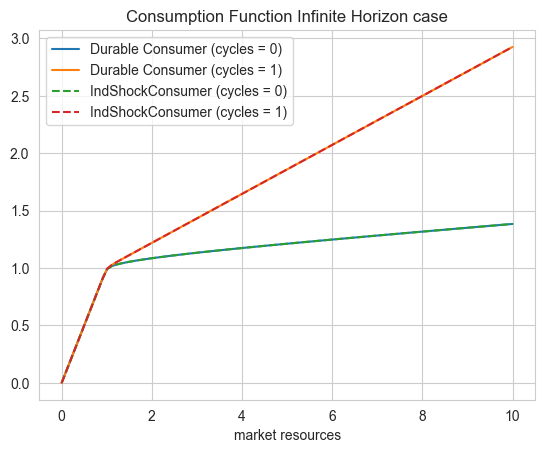

In [23]:
plt.plot(grid, Results_inf['cFunc_test'], label = "Durable Consumer (cycles = 0)")
plt.plot(grid, Results_life['cFunc_test'], label = "Durable Consumer (cycles = 1)")
plt.plot(grid, cFunc_IndShock_inf, '--' , label = "IndShockConsumer (cycles = 0)")
plt.plot(grid, cFunc_IndShock_life, '--' , label = "IndShockConsumer (cycles = 1)")
plt.title('Consumption Function Infinite Horizon case')
plt.xlabel('market resources')
plt.legend()
plt.show()

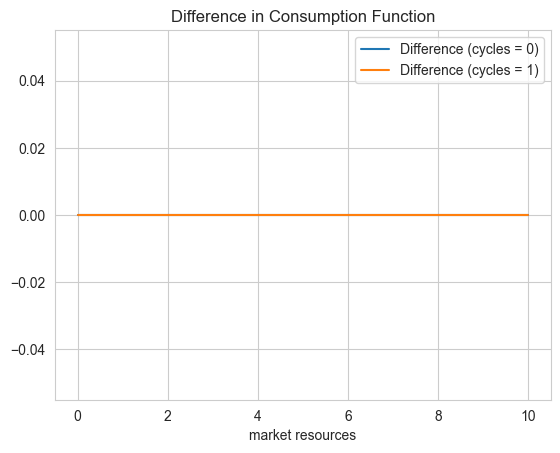

In [24]:
plt.plot(grid, Results_inf['cFunc_test'] - cFunc_IndShock_inf, label = "Difference (cycles = 0)")
plt.plot(grid, Results_life['cFunc_test'] - cFunc_IndShock_life, label = "Difference (cycles = 1)")
plt.title('Difference in Consumption Function')
plt.xlabel('market resources')
plt.legend()
plt.show()

Indeed, it is exactly the same!

# 5. Bottleneck
### 5a) Two Non-Durable Good Example
As great as the code is, there are still some (minor) problems. For instance, let's take the case when depreciation is 1 and we derive as much utility from good 1 as we do from good 2 (alpha = 0.5). The agent should consume exactly the same for both goods. Let's see how it works:

In [25]:
TwoGoodExample = deepcopy(DurableExample_life)
TwoGoodExample.alpha = 0.5
TwoGoodExample.dDepr = 1
TwoGoodExample.adjC = 1
TwoGoodExample.d_ubar = 0.01
TwoGoodExample.nNrmCount = 100
TwoGoodExample.mNrmCount = 100
TwoGoodExample.xNrmCount = 100
TwoGoodExample.mNrmMax = 25
TwoGoodExample.nNrmMax = 25
TwoGoodExample.aXtraCount = 100
TwoGoodExample.AdjX = True
TwoGoodExample.update()
TwoGoodExample.solve()

Consumption function for an idiosyncratic shocks consumer type with durable stock = 0 alpha 0.5 , and Adjustment Costs 1


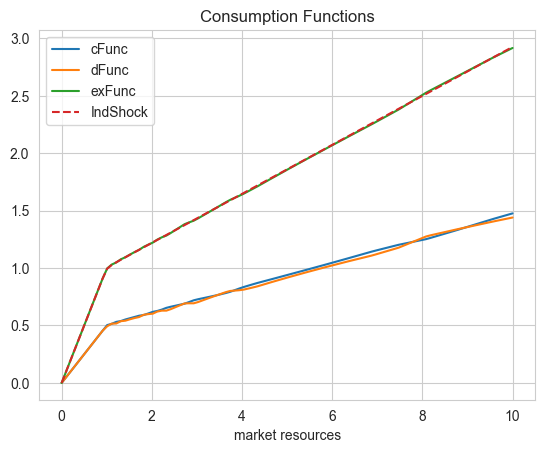

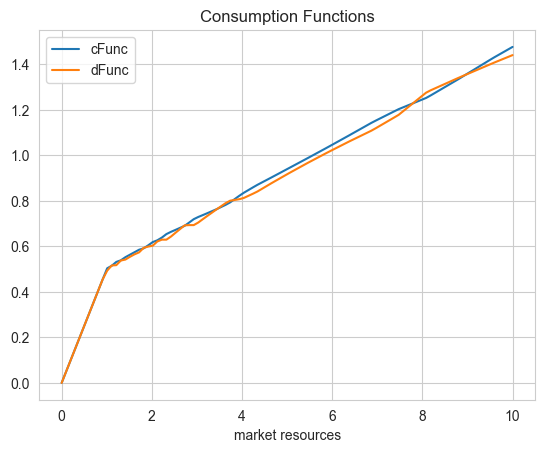

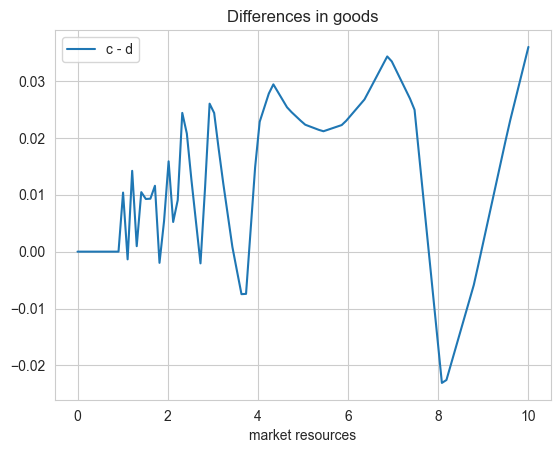

In [26]:
n = 0
print('Consumption function for an idiosyncratic shocks consumer type with durable stock =', n, 'alpha', TwoGoodExample.alpha, ', and Adjustment Costs', TwoGoodExample.adjC)
Results = Graphfunctions(TwoGoodExample, 0, grid, n)
plt.plot(grid, Results['cFunc_test'], label = "cFunc")
plt.plot(grid, Results['dFunc_test'], label = "dFunc")
plt.plot(grid, Results['exFunc_test'], label = "exFunc")
plt.plot(grid,cFunc_IndShock_life, '--', label = "IndShock")
plt.title('Consumption Functions')
plt.xlabel('market resources')
plt.legend()
plt.show()

plt.plot(grid, (Results['cFunc_test']), label = "cFunc")
plt.plot(grid, (Results['dFunc_test']), label = "dFunc")
plt.title('Consumption Functions')
plt.xlabel('market resources')
plt.legend()
plt.show()

plt.plot(grid, Results['cFunc_test'] - Results['dFunc_test'], label = "c - d")
plt.title('Differences in goods')
plt.xlabel('market resources')
plt.legend()
plt.show()

ALAS poor DurableConsumerType!

While the total expenditure function is still the same, we consume slightly different quantities of both goods! The reason for this is that we solve the adjuster buy maximizing over the inverse value function of the keeper. This is numerically difficult as the peak of the objective function is not steep.


## 5b) Adding Shocks
What happens if we include uncertainty? Does the solution stays close or do we see a convergence?

### i) Permanent Shocks

In [27]:
### Solve IndShockConsumerType: Lifecycle
IndShockExample_life_perm = deepcopy(IndShockExample_life)
IndShockExample_life_perm.PermShkStd = [0.06] * T_cycle
IndShockExample_life_perm.update()
IndShockExample_life_perm.solve()

grid = np.linspace(0,10,100)
cFunc_IndShock_life_perm = np.zeros(len(grid))
for i in range(len(grid)):
    cFunc_IndShock_life_perm[i] = IndShockExample_life_perm.solution[3].cFunc(grid[i])

In [28]:
### Solve IndShockConsumerType: Infinite Horizon
IndShockExample_inf_perm = deepcopy(IndShockExample_inf)
IndShockExample_inf_perm.cycles = 0
IndShockExample_inf_perm.PermShkStd = [0.06] * T_cycle
IndShockExample_inf_perm.update_income_process()
IndShockExample_inf_perm.solve()

grid = np.linspace(0,10,100)
cFunc_IndShock_inf_perm = np.zeros(len(grid))
for i in range(len(grid)):
    cFunc_IndShock_inf_perm[i] = IndShockExample_inf_perm.solution[0].cFunc(grid[i])

In [29]:
### Solve DurableConsumerType: Lifecycle
DurableExample_life_perm = deepcopy(DurableExample_life)
DurableExample_life_perm.PermShkStd = [0.06] * T_cycle
DurableExample_life_perm.update()
DurableExample_life_perm.solve()
n = 0
Results_life_perm = Graphfunctions(DurableExample_life_perm,3,grid,n)

In [30]:
### Solve DurableConsumerType: Infinite Horizon
DurableExample_inf_perm = deepcopy(DurableExample_inf)
DurableExample_inf_perm.cycles = 0
DurableExample_inf_perm.PermShkStd = [0.06] * T_cycle
DurableExample_inf_perm.update_income_process()
DurableExample_inf_perm.solve()
n = 0
Results_inf_perm = Graphfunctions(DurableExample_inf_perm,0,grid,n)

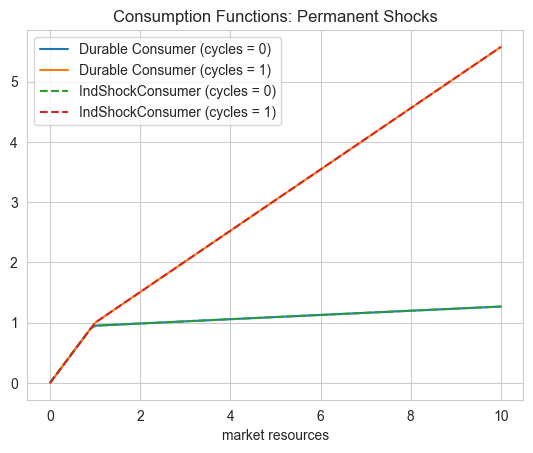

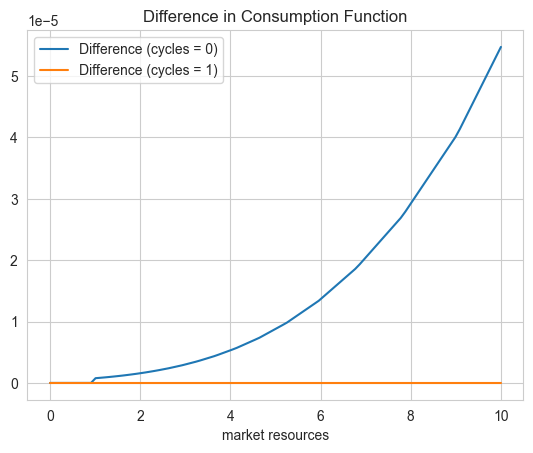

In [31]:
plt.plot(grid, Results_inf_perm['cFunc_test'], label = "Durable Consumer (cycles = 0)")
plt.plot(grid, Results_life_perm['cFunc_test'], label = "Durable Consumer (cycles = 1)")
plt.plot(grid, cFunc_IndShock_inf_perm, '--' , label = "IndShockConsumer (cycles = 0)")
plt.plot(grid, cFunc_IndShock_life_perm, '--' , label = "IndShockConsumer (cycles = 1)")
plt.title('Consumption Functions: Permanent Shocks')
plt.xlabel('market resources')
plt.legend()
plt.show()

plt.plot(grid, Results_inf_perm['cFunc_test'] - cFunc_IndShock_inf_perm, label = "Difference (cycles = 0)")
plt.plot(grid, Results_life_perm['cFunc_test'] - cFunc_IndShock_life_perm, label = "Difference (cycles = 1)")
plt.title('Difference in Consumption Function')
plt.xlabel('market resources')
plt.legend()
plt.show()

### ii) Transitory Shocks

In [32]:
### Solve IndShockConsumerType: Lifecycle
IndShockExample_life_tran = deepcopy(IndShockExample_life)
IndShockExample_life_tran.TranShkStd = [0.06] * T_cycle
IndShockExample_life_tran.update_income_process()
IndShockExample_life_tran.solve()

grid = np.linspace(0,10,100)
cFunc_IndShock_life_tran = np.zeros(len(grid))
for i in range(len(grid)):
    cFunc_IndShock_life_tran[i] = IndShockExample_life_tran.solution[3].cFunc(grid[i])

In [33]:
### Solve IndShockConsumerType: Infinite Horizon
IndShockExample_inf_tran = deepcopy(IndShockExample_inf)
IndShockExample_inf_tran.cycles = 0
IndShockExample_inf_tran.TranShkStd = [0.06] * T_cycle
IndShockExample_inf_tran.update_income_process()
IndShockExample_inf_tran.solve()

grid = np.linspace(0,10,100)
cFunc_IndShock_inf_tran = np.zeros(len(grid))
for i in range(len(grid)):
    cFunc_IndShock_inf_tran[i] = IndShockExample_inf_tran.solution[0].cFunc(grid[i])

In [34]:
### Solve DurableConsumerType: Lifecycle
DurableExample_life_tran =  deepcopy(DurableExample_life)
DurableExample_life_tran.TranShkStd = [0.06] * T_cycle
DurableExample_life_tran.update_income_process()
DurableExample_life_tran.solve()
n = 0
Results_life_tran = Graphfunctions(DurableExample_life_tran,3,grid,n)


In [35]:
### Solve DurableConsumerType: Infinite Horizon
DurableExample_inf_tran =  deepcopy(DurableExample_inf)
DurableExample_inf_tran.cycles = 0
DurableExample_inf_tran.TranShkStd = [0.06] * T_cycle
DurableExample_inf_tran.update_income_process()
DurableExample_inf_tran.solve()
n = 0
Results_inf_tran = Graphfunctions(DurableExample_inf_tran,0,grid,n)

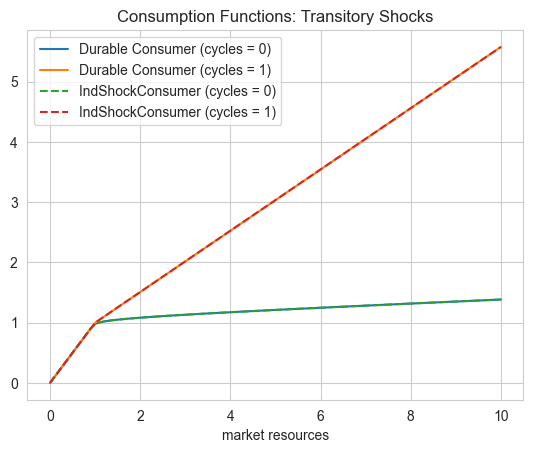

In [36]:
plt.plot(grid, Results_inf_tran['cFunc_test'], label = "Durable Consumer (cycles = 0)")
plt.plot(grid, Results_life_tran['cFunc_test'], label = "Durable Consumer (cycles = 1)")
plt.plot(grid, cFunc_IndShock_inf_tran, '--' , label = "IndShockConsumer (cycles = 0)")
plt.plot(grid, cFunc_IndShock_life_tran, '--' , label = "IndShockConsumer (cycles = 1)")
plt.title('Consumption Functions: Transitory Shocks')
plt.xlabel('market resources')
plt.legend()
plt.show()

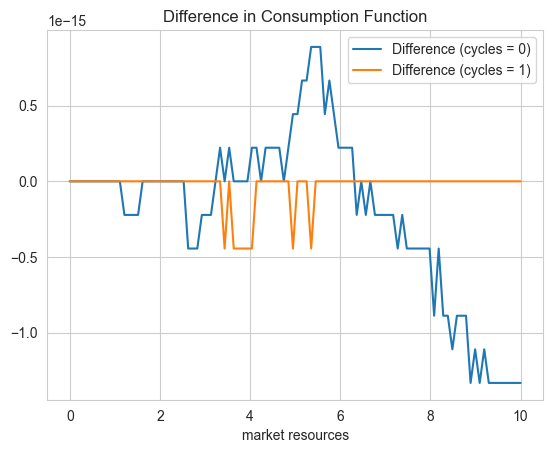

In [37]:
plt.plot(grid, Results_inf_tran['cFunc_test'] - cFunc_IndShock_inf_tran, label = "Difference (cycles = 0)")
plt.plot(grid, Results_life_tran['cFunc_test'] - cFunc_IndShock_life_tran, label = "Difference (cycles = 1)")
plt.title('Difference in Consumption Function')
plt.xlabel('market resources')
plt.legend()
plt.show()

### Result:
Permanent shocks create a small wedge between the two types which is visible in the infinite horizon model.
The reason for this is that `IndShockConsumer` uses a limit function as it converges to the perfect foresight case. This option is still work in progress for `DurableConsumer`.
Keep this in mind when using the solver!